<a href="https://colab.research.google.com/github/FurukuOnTour/nlpsys-project-legalnlp/blob/main/Model/BERT_NLP_III_All2Favor_(test%2Bdev).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT

In [ ]:
import pandas as pd
import re

### CHECK AND PREPARE DATA

In [ ]:
!gdown --id 1IvPNfORnBtDSoxwH5D8S9lqV3Hcu_Pmy 

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IvPNfORnBtDSoxwH5D8S9lqV3Hcu_Pmy
To: /content/all2favor_all.csv
100% 4.86M/4.86M [00:00<00:00, 288MB/s]


In [ ]:
data = pd.read_csv('/content/all2favor_all.csv')

In [ ]:
from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(data, train_size=0.8, random_state=77)

labels = list(set(data['label'].to_list()))
label_to_idx = {label:i for i,label in enumerate(labels)}
label_list = [0] * len(labels)

label_list = [0] * len(label_to_idx)
for label in label_to_idx:
  label_list[label_to_idx[label]] = label 

train_df['label'] = train_df['label'].apply(lambda x: label_to_idx[x])
dev_df['label'] = dev_df['label'].apply(lambda x: label_to_idx[x])

# Transformer

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  1 06:49:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import (
    AutoTokenizer, 
    AutoModel,
    AutoModelForSequenceClassification, 
    AutoConfig,

    Trainer, 
    TrainingArguments,
)

from datasets import (
    Dataset,
    DatasetDict,
    Features, Sequence, ClassLabel, Value
)

In [ ]:
model_name = 'airesearch/wangchanberta-base-att-spm-uncased'
config = AutoConfig.from_pretrained(model_name, num_labels=len(labels))
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           config=config)



Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

# Use Dataset Module

In [ ]:
train_dict = train_df.to_dict('series')
dev_dict = dev_df.to_dict('series')

In [ ]:
features= Features({
                    "text": Value(dtype='string'),
                    "label": ClassLabel(names=label_list)
                })
d = DatasetDict({'train': Dataset.from_dict(train_dict, features=features), 
                 'dev': Dataset.from_dict(dev_dict, features=features)})

In [ ]:
d

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 304
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 76
    })
})

In [ ]:
d['train'][0]

{'text': '2547/269 ย่อสั้น คำพิพากษาศาลฎีกาซึ่งยกฟ้องจำเลยที่ 2 ในข้อหาขับรถโดยประมาทเป็นเหตุให้ผู้อื่นได้รับอันตรายแก่กาย ได้รับอันตรายสาหัส และถึงแก่ความตาย มีประเด็นตรงกับประเด็นในคดีนี้ที่ว่า จำเลยที่ 2 ขับรถด้วยความประมาทเลินเล่อปราศจากความระมัดระวังตามที่โจทก์ที่ 1 ฟ้องหรือไม่ เมื่อโจทก์ที่ 1 และจำเลยที่ 2 เป็นคู่ความในคดีดังกล่าว จึงต้องผูกพันตามคำพิพากษาคดีอาญาดังกล่าว คดีนี้เป็นคดีแพ่งที่เกี่ยวเนื่องกับคดีอาญาในการพิพากษาคดีส่วนแพ่ง ศาลจำต้องถือข้อเท็จจริงตามที่ปรากฏในคำพิพากษาคดีส่วนอาญาจึงต้องฟังว่าจำเลยที่ 2 มิได้ขับรถด้วยความประมาทเลินเล่อเป็นเหตุให้ผู้อื่นถึงแก่ความตายได้รับอันตรายสาหัสและได้รับอันตรายแก่กายตามฟ้อง เมื่อจำเลยที่ 2 มิได้กระทำละเมิดต่อโจทก์ที่ 1 จำเลยที่ 1 ซึ่งเป็นนายจ้างของจำเลยที่ 2 จึงไม่ต้องรับผิดใช้ค่าสินไหมทดแทนตามที่โจทก์ที่ 1 ฟ้องด้วย การที่ศาลอุทธรณ์พิพากษายืนตามคำพิพากษาของศาลชั้นต้น ให้จำเลยที่ 3 ถึงที่ 6 ชดใช้เงินแก่โจทก์ที่ 3 ที่ 8 ที่ 17 ที่ 56 และที่ 63 เกินกว่าจำนวนที่ปรากฏในคำขอท้ายฟ้องโจทก์แต่ละคนดังกล่าวนั้น เป็นปัญหาข้อกฎหมายอันเกี่ยวกับ

# Tokenize

In [ ]:
def tokenize(examples):
    tokenized_inputs = tokenizer(examples["text"], 
                                 is_split_into_words=False,
                                 truncation=True,
                                 max_length=256)
    return tokenized_inputs
tokenized_datasets = d.map(tokenize, batched=True)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_datasets['train'][0]['input_ids'])

['<s>',
 '▁',
 '2547',
 '/2',
 '69',
 '▁',
 'ย่อ',
 'สั้น',
 '▁',
 'คําพิพากษา',
 'ศาลฎีกา',
 'ซึ่ง',
 'ยกฟ้อง',
 'จําเลยที่',
 '▁',
 '2',
 '▁',
 'ในข้อหา',
 'ขับรถ',
 'โดยประมาท',
 'เป็นเหตุ',
 'ให้ผู้อื่น',
 'ได้รับ',
 'อันตราย',
 'แก่',
 'กาย',
 '▁',
 'ได้รับ',
 'อันตราย',
 'สาหัส',
 '▁และ',
 'ถึง',
 'แก่ความตาย',
 '▁',
 'มีประเด็น',
 'ตรงกับ',
 'ประเด็น',
 'ในคดีนี้',
 'ที่ว่า',
 '▁',
 'จําเลยที่',
 '▁',
 '2',
 '▁',
 'ขับรถ',
 'ด้วยความ',
 'ประมาท',
 'เ',
 'ลิน',
 'เล่อ',
 'ปราศจาก',
 'ความ',
 'ระมัดระวัง',
 'ตามที่',
 'โจทก์',
 'ที่',
 '▁',
 '1',
 '▁',
 'ฟ้อง',
 'หรือไม่',
 '▁เมื่อ',
 'โจทก์',
 'ที่',
 '▁',
 '1',
 '▁และ',
 'จําเลยที่',
 '▁',
 '2',
 '▁',
 'เป็นคู่',
 'ความ',
 'ในคดี',
 'ดังกล่าว',
 '▁จึงต้อง',
 'ผูกพัน',
 'ตาม',
 'คําพิพากษา',
 'คดีอาญา',
 'ดังกล่าว',
 '▁',
 'คดีนี้',
 'เป็น',
 'คดีแพ่ง',
 'ที่',
 'เกี่ยว',
 'เนื่องกับ',
 'คดีอาญา',
 'ในการ',
 'พิพากษา',
 'คดี',
 'ส่วน',
 'แพ่ง',
 '▁ศาล',
 'จําต้อง',
 'ถือ',
 'ข้อเท็จ',
 'จริง',
 'ตาม',
 'ที่ปรากฏใน',
 'คําพิพากษา'

# Prepare Model

In [ ]:
model_name.split('/')[-1]

'wangchanberta-base-att-spm-uncased'

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer,
                                        padding=True, pad_to_multiple_of=8)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets["train"].column_names

['label', 'input_ids', 'attention_mask']

In [ ]:
tokenized_datasets['dev'][20]

{'label': 2,
 'input_ids': [5,
  10,
  24330,
  101,
  203,
  4515,
  10,
  4283,
  1886,
  10,
  5202,
  23632,
  854,
  15562,
  54,
  1283,
  17832,
  1710,
  13758,
  9765,
  854,
  1809,
  166,
  15228,
  390,
  15,
  5202,
  37,
  2263,
  1983,
  18772,
  31,
  7809,
  54,
  17712,
  24,
  19337,
  178,
  72,
  78,
  10,
  4283,
  623,
  10,
  3897,
  1809,
  27,
  3897,
  15,
  2370,
  854,
  718,
  183,
  26,
  233,
  10,
  15964,
  10,
  68,
  10,
  2052,
  254,
  213,
  454,
  23632,
  12,
  718,
  44,
  54,
  133,
  17832,
  2844,
  16,
  13758,
  10,
  3897,
  141,
  1809,
  506,
  2672,
  854,
  5713,
  3897,
  9787,
  15228,
  2052,
  390,
  10,
  2052,
  8965,
  12,
  5091,
  3897,
  17,
  30,
  3036,
  5783,
  554,
  543,
  60,
  238,
  130,
  5816,
  1602,
  3570,
  13758,
  13,
  600,
  1809,
  27,
  2052,
  211,
  1885,
  2370,
  13758,
  13,
  2052,
  94,
  18772,
  1101,
  10,
  3897,
  5050,
  1496,
  1809,
  12559,
  526,
  22,
  12135,
  90,
  11007,
  2052,
  3

In [ ]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items()}
[len(x) for x in samples["input_ids"]]

[256, 256, 256, 192, 143, 256, 256, 256]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([8, 256]),
 'attention_mask': torch.Size([8, 256]),
 'labels': torch.Size([8])}

In [ ]:
from datasets import list_metrics, load_metric
list_metrics()

<ipython-input-22-3cf64b9e62a1>:2: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  list_metrics()


['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'brier_score',
 'cer',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'exact_match',
 'f1',
 'frugalscore',
 'glue',
 'google_bleu',
 'indic_glue',
 'mae',
 'mahalanobis',
 'mape',
 'mase',
 'matthews_correlation',
 'mauve',
 'mean_iou',
 'meteor',
 'mse',
 'pearsonr',
 'perplexity',
 'poseval',
 'precision',
 'recall',
 'rl_reliability',
 'roc_auc',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'smape',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'trec_eval',
 'wer',
 'wiki_split',
 'xnli',
 'xtreme_s',
 'Drunper/metrica_tesi',
 'Felipehonorato/my_metric',
 'GMFTBY/dailydialog_evaluate',
 'GMFTBY/dailydialogevaluate',
 'JP-SystemsX/nDCG',
 'KevinSpaghetti/accuracyk',
 'NCSOFT/harim_plus',
 'NikitaMartynov/spell-check-metric',
 'NimaBoscarino/weat',
 'Ochiroo/rouge_mn',
 'Vertaix/vendiscore',
 'Viona/infolm',
 'Vlasta/pr_auc',
 'abdusah/aradiawer',
 'abidlabs/mean_iou',
 'abidlabs/mean_iou2',
 '

In [ ]:
load_metric('accuracy')

<ipython-input-23-180ef0c0d6c3>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_metric('accuracy')


Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = datasets.load_metric("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
        {'accuracy': 0.5}

   

# Training a.k.a. babysitting

In [ ]:
args = TrainingArguments(
    output_dir='nlp_III'
)

args2 = TrainingArguments(
    output_dir='nlp_law',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,  
)
import numpy as np

def compute_metrics(eval_preds):
  metric = load_metric("accuracy")
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model,
    args2,
    train_dataset=tokenized_datasets["train"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 304
  Num Epochs = 10
  Instantaneous batch size per d

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=190, training_loss=0.17786331176757814, metrics={'train_runtime': 144.6421, 'train_samples_per_second': 21.017, 'train_steps_per_second': 1.314, 'total_flos': 399935985745920.0, 'train_loss': 0.17786331176757814, 'epoch': 10.0})

In [ ]:
predictions = trainer.predict(tokenized_datasets['dev'])
preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 76
  Batch size = 16


In [ ]:
predictions

PredictionOutput(predictions=array([[-0.2976758 , -1.2889723 ,  4.392546  , -3.1200294 ],
       [-1.1736763 ,  5.759542  , -1.757885  , -2.5369415 ],
       [ 5.4159017 , -1.5092775 , -0.79681516, -2.4689927 ],
       [-0.17452627, -2.7269278 ,  4.3028235 , -2.02286   ],
       [-0.4895086 ,  5.7312407 , -2.2923644 , -1.8227981 ],
       [ 5.1436577 , -2.8871593 ,  0.7056568 , -2.597192  ],
       [-2.7462242 ,  5.4570866 , -0.43386212, -1.8233886 ],
       [-0.8131154 ,  2.8059444 , -1.9613886 ,  0.6685422 ],
       [ 3.3993094 ,  1.8754436 , -0.67666215, -3.7461784 ],
       [ 4.0747466 , -1.9341645 ,  1.6515377 , -3.4882298 ],
       [-2.9645128 ,  4.973087  , -1.5845639 , -0.30747846],
       [ 5.4710007 , -2.5399504 , -0.01585199, -2.2113469 ],
       [-1.1466454 , -1.2618296 ,  4.226759  , -2.1484892 ],
       [-0.8445054 ,  5.7555313 , -2.8457232 , -0.86735535],
       [-0.52502435,  2.7188852 , -1.9798238 ,  0.58032024],
       [-0.2434107 , -1.349763  , -1.6565403 ,  3.922629

In [ ]:
predictions.label_ids

array([2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 2, 3, 2, 3, 2, 0, 3, 2, 2, 0,
       2, 3, 3, 1, 1, 0, 0, 0, 2, 1, 3, 0, 2, 3, 0, 1, 1, 3, 1, 0, 0, 1,
       0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 3, 1, 0, 1, 0, 1, 3, 2, 1, 2,
       0, 1, 0, 3, 2, 0, 1, 0, 0, 3])

In [ ]:
preds

array([2, 1, 0, 2, 1, 0, 1, 1, 0, 0, 1, 0, 2, 1, 1, 3, 2, 0, 0, 0, 2, 0,
       2, 3, 3, 1, 1, 0, 0, 0, 2, 1, 1, 2, 2, 3, 0, 0, 1, 3, 1, 0, 2, 0,
       0, 0, 0, 3, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 3, 2, 1, 2,
       0, 3, 0, 2, 1, 0, 1, 0, 0, 3])

In [ ]:
predicted_labels = [labels[x] for x in preds]
gold = [labels[x] for x in predictions.label_ids]

# Evaluation

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(gold, predicted_labels))

                     precision    recall  f1-score   support

          favorable       0.75      0.71      0.73        17
              other       0.78      0.58      0.67        12
partially favorable       0.81      0.90      0.85        29
        unfavorable       0.74      0.78      0.76        18

           accuracy                           0.78        76
          macro avg       0.77      0.74      0.75        76
       weighted avg       0.78      0.78      0.77        76



# 90 epoch


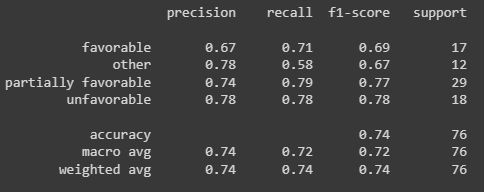

# 90+20 Epoch


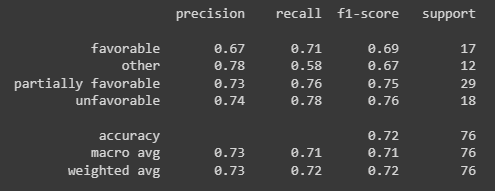

# 10+10 Epochs
- tokenizer max length = 256
- learning_rate=3e-5
- per_device_train_batch_size=16
- per_device_eval_batch_size=16
- num_train_epochs=10+10

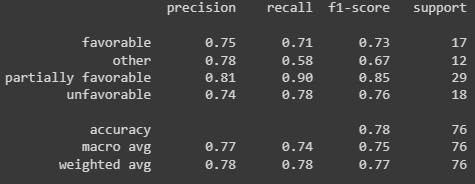